<a href="https://colab.research.google.com/github/JacopoKahl/CycleGAN/blob/main/CycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CycleGAN

Composed by 4 models: 2 generators and 2 discriminators

**Objective**: Train generators (together with discriminators) to be able to transgorm input images.

**Dataset**: apple2orange image dataset

**Notation**:

1.   **g_AB**: Generator for A->B image conversion
2.   **G_BA**: Generator for B->A image conversion
3.   **d_A**: Discriminator for A type images
4.   **d_B**: Discriminator for B type images



In [35]:
%tensorflow_version 1.x

##Imports


*   Need to install keras-contrib from GitHub!



In [36]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-of_f4m4k
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-of_f4m4k
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101066 sha256=c2fa3d567678399cf3ef5bab3e02d4e94490dee074304d3e29ef24e6dd7c6718
  Stored in directory: /tmp/pip-ephem-wheel-cache-_0lx268u/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [37]:
from keras.models import Model #Keras Functional API

from keras.layers import Input, Conv2D, UpSampling2D, Activation, LeakyReLU, Concatenate, BatchNormalization, Dropout

from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization #InstanceNormalization layer is part of keras.contrib installed above

#from keras.initializers import RandomNormal

from keras.optimizers import Adam #import adam to specify settings

import numpy as np #import numpy numerical library

from glob import glob #glob is a function used for listing file path

from PIL import Image #Python Imaging library used here for simply opening image files and transforming input into bitmap format. Here only the Image class is imported.
#import cv2 #alternatively one can import the OpenCV library (famous for image processing)

#Visualization
import matplotlib.pyplot as plt #plot charts

from keras.utils import plot_model #visualization chart of the models

from tqdm import tqdm #progress bar

##Dataset 

https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Dataset

###Unzip and prepare working directory

In [22]:
#print working directory
%pwd

'/content/drive/My Drive/AI_for_Multimedia/Lezione12'

In [23]:
#print list files
%ls

apple2orange.zip


In [24]:
%cd '/content/drive/MyDrive/AI_for_Multimedia/Lezione12/'

/content/drive/MyDrive/AI_for_Multimedia/Lezione12


In [ ]:
#print list files
%ls

apple2orange.zip


In [ ]:
!unzip -q apple2orange.zip -d /content/

In [25]:
%cd /content/apple2orange/

/content/apple2orange


In [27]:
%ls

testA/  testB/  trainA/  trainB/


In [39]:
#Create image file lists

trainA_files = glob('trainA/*.jpg')
trainB_files = glob('trainB/*.jpg')

testA_files = glob('testA/*.jpg')
testB_files = glob('testB/*.jpg')

##Explore dataset

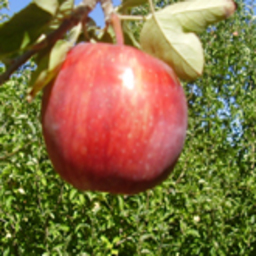

In [40]:
index = 0
img = Image.open(trainA_files[index])

img

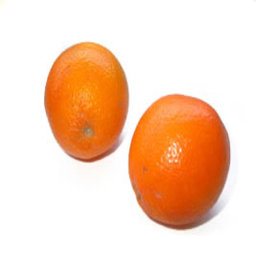

In [41]:
img = Image.open(trainB_files[index])

img

In [42]:
#Function to convert images into elments of a numpy array
#The function returns a numpy array of bitmaps

def files2array (filelist, image_wh=(128,128)):
  return np.array([np.array(Image.open(fname).resize(image_wh)) for fname in filelist])


In [43]:
#This cell generates the train and test arrays by calliung the files2array function defined above

image_dim = (128,128) #resolution after resize

X_trainA = files2array(trainA_files, image_dim) / 127.5 - 1.
X_trainB = files2array(trainB_files, image_dim) / 127.5 - 1.

X_testA = files2array(testA_files, image_dim) / 127.5 - 1.
X_testB = files2array(testB_files, image_dim) / 127.5 - 1.

In [44]:
print('X_trainA shape: ', X_trainA.shape)
print('X_trainB shape: ', X_trainB.shape)

print('X_testA shape: ', X_testA.shape)
print('X_testB shape: ', X_testB.shape)

X_trainA shape:  (995, 128, 128, 3)
X_trainB shape:  (1019, 128, 128, 3)
X_testA shape:  (266, 128, 128, 3)
X_testB shape:  (248, 128, 128, 3)


##Settings

In [45]:
input_dim = X_trainA.shape[1:]
learning_rate = 0.0002

#Weights for loss functions
lambda_validation = 1
lambda_reconstr = 10
lambda_id = 2

genrator_type = 'u-net'

#Filters number (will be multiplied in the model) from generator and discriminator
gen_n_filters = 32
disc_n_filters = 32

epochs = 10

##Generators

In [47]:
def build_generator_unet(img_shape, model_name):

  #Function for building one downsampling block
  def downsample(layer_input, filters, f_size=4):
    d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
    d = InstanceNormalization(axis = -1, center=False, scale=False)(d)
    d = Activation('relu')(d)
    return d

  #Function for building one upsampling block
  def upsample(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
    u = UpSampling2D(size=2)(layer_input)
    u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same')(u)
    u = InstanceNormalization(axis = -1, center=False, scale=False)(u)
    u = Activation('relu')(u)

    if dropout_rate:
      u = Dropout(dropout_rate)(u) #optional dropout layer
    u = Concatenate()([u, skip_input]) #concatenate (processed) output from previous upsampling block with skip connection input
    return u

  #Instructions of the build_generator_unet function ---------------------
  
  img = Input(shape=img_shape) #Input layer

  #Downsampling blocks
  d1 = downsample(img, gen_n_filters) #1st downsampling block
  d2 = downsample(d1, gen_n_filters * 2) #2nd downsampling block
  d3 = downsample(d2, gen_n_filters * 4) #3rd downsampling block
  d4 = downsample(d3, gen_n_filters * 8) #4th downsampling block

  #Upsampling blocks (note double input to the function: from previous block and skip connection)
  u1 = upsample(d4, d3, gen_n_filters * 4) #1st upsampling block
  u2 = upsample(u1, d2, gen_n_filters * 2) #2nd upsampling block
  u3 = upsample(u2, d1, gen_n_filters * 2) #3rd upsampling block
  u4 = UpSampling2D(size=2)(u3)            #4th upsampling block
  output = Conv2D(filters=img_shape[2], kernel_size=4, strides=1, padding='same', activation='tanh') (u4)

  return Model(img, output, name=model_name)
  